In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params, configure_plot_params

configure_plot_params(fontsize=12)

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

# exposure = 5 * 14000 / (4 * np.pi)
# p = update_params(param_file, p, 'exposure', exposure)

# phipp = 7.12073e-30
# fwimp = phipp * 8 * np.pi / 1e-28
# # fwimp = 1e-4
# p = update_params(param_file, p, 'fwimp', fwimp)

# p = update_params(param_file, p, 'bg', 1)
# p = update_params(param_file, p, 'beg', 1)

# print(exposure, fwimp)
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.1,
 'M_max': 10000000000.0,
 'fwimp': 1.78,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -16,
 'log_flux_max': -2,
 'N': 2200,
 'log_k_min': -2,
 'log_k_max': 10,
 'N_k': 250000,
 'psh_log_f_min': -7,
 'psh_log_f_max': -1.0,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008615905978150363,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1,
 'beta': 1.9}

In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], input_file='./output/n0_pshfunc_paper.npz', return_all=True)
s_psh = s_psh[::1]
s_fluxes = s_fluxes[::1]
print(s_psh.shape)
print(np.trapz(s_psh, s_fluxes, axis=0))
s_psh /= np.trapz(s_psh, s_fluxes, axis=0)
print(np.trapz(s_psh, s_fluxes, axis=0))

## SOM
som_fwimp_rescale = 9.0298
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], input_file='./output/n-1_pshfunc_paper.npz', return_all=True, rescale=som_fwimp_rescale)
som_psh = som_psh[::1]
som_fluxes = som_fluxes[::1]
print(np.trapz(som_psh, som_fluxes, axis=0))
som_psh /= np.trapz(som_psh, som_fluxes, axis=0)
print(som_psh.shape, som_fluxes.shape)

# som_psh /= som_fwimp_rescale
# som_fluxes *= som_fwimp_rescale
print(np.trapz(som_psh, som_fluxes, axis=0))

# print(s_fluxes, som_fluxes)

(100, 70144)
[1.00042866 1.00042866 1.00042866 ... 1.00043519 1.00043519 1.00043519]
[1. 1. 1. ... 1. 1. 1.]
[1.00032751 1.00032751 1.00032751 ... 1.00032763 1.00032763 1.00032763]
(100, 70144) (100,)
[1. 1. 1. ... 1. 1. 1.]


In [6]:
# search parameters
num_search = 60
p['fwimp'] *= 1

fwimps = np.logspace(np.log10(p['fwimp'])-.75, np.log10(p['fwimp'])+.75, num_search)
begs = np.linspace(.925, 1.075, num=num_search)

# exposure_search = np.logspace(0, 1, num=1) * p['exposure']
exposure_search = np.array([5]) * p['exposure']

In [7]:
 def likelihood_run_for_model_2d(p, psh, fluxes, poisson_rescale=1, model='', som_fwimp_rescale=1, s_fwimp_rescale=1):
    # run likelihoods
    s_S = np.zeros((len(exposure_search), len(begs), num_search))
    som_S = np.zeros((len(exposure_search), len(begs), num_search))
    poisson_S = np.zeros((len(exposure_search), len(begs), num_search))

    for i, exposure in enumerate(exposure_search):
        p['exposure'] = exposure

        gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure'] * p['bg']
        iso_bg = p['iso_flux_bg'] * p['exposure'] * p['beg']
        bg_count = gal_bg + iso_bg

        counts = np.arange(0, bg_count.max() + 4 * np.sqrt(bg_count.max()) + p['exposure'] * p['fwimp'] * fluxes.max())

        print('calculating pc to count =', counts[-1])

        unique_ang, uni_ind, uni_inv = np.unique(np.abs(ang_dists[good_indices]), return_inverse=True, return_index=True)
        
        print('psh mean', np.trapz(fluxes * psh[:, 0], fluxes))

        pshdat = psh[:, uni_ind]
        psh = pshdat[:, uni_inv]
        if model == 's':
            spsh = pshdat[:, uni_inv]
            sompsh = som_psh
        elif model == 'som':
            sompsh = pshdat[:, uni_inv]
            spsh = s_psh
        else:
            spsh = s_psh
            sompsh = som_psh

        if model == '':
            pc_psi = stats.poisson.pmf(counts[np.newaxis, :], np.trapz(psh * fluxes[:, np.newaxis] * p['exposure'] * p['fwimp'], fluxes[:, np.newaxis], axis=0)[:, np.newaxis])
        else:
            pc_psi = integrate.simps(pshdat[..., np.newaxis] * stats.poisson.pmf(counts[np.newaxis, np.newaxis, :], p['exposure'] * p['fwimp'] * fluxes[:, np.newaxis, np.newaxis]), fluxes, axis=0)
            pc_psi /= np.sum(pc_psi, axis=-1)[:, np.newaxis]

        print('is pc norm', np.allclose(np.sum(pc_psi, axis=-1), 1))
        print('last pc prob', pc_psi[:, -1])

        pc_of_psi = pc_psi[uni_inv]

        # generate sky map
        subcounts = pd.generate_skymap_sample_pc(p, pc_of_psi, ang_dists[good_indices], good_indices, return_subcounts=True, save_output=True, bg_counts=bg_count)

        print('generated skymap with', p['fwimp'])
        print('max counts', counts[-1], subcounts.max())

        if model == 'minimize':
            from scipy.optimize import minimize

#             indmax = np.unravel_index(np.argmin(s_S, axis=None), s_S.shape)

            s_max = minimize(pd.likelihood2d, [exposure_search[0], p['beg'], p['fwimp']], args=(spsh, subcounts.astype(np.int16), s_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
            print('swave\t', s_max)

            som_max = minimize(pd.likelihood2d, [exposure_search[0], p['beg'], p['fwimp']], args=(sompsh, subcounts.astype(np.int16), som_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
            print('som\t', som_max)

            poi_max = minimize(pd.poisson_likelihood2d, [exposure_search[0], p['beg'], p['fwimp']], args=(psh, subcounts.astype(np.int16), fluxes, iso_bg, gal_bg), method='Nelder-Mead')
            print('poi\t', poi_max)
            return None

        for j, beg in enumerate(begs):
            for k, fwimp in enumerate(fwimps):
                S = pd.likelihood2d([exposure, beg, fwimp * s_fwimp_rescale], spsh, subcounts.astype(np.int16), s_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                s_S[i, j, k] = S

                S = pd.likelihood2d([exposure, beg, fwimp * som_fwimp_rescale], sompsh, subcounts.astype(np.int16), som_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                som_S[i, j, k] = S

                S = pd.poisson_likelihood2d([exposure, beg, fwimp/poisson_rescale], psh, subcounts.astype(np.int16), fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                poisson_S[i, j, k] = S

        print(i+1, '/', len(exposure_search))
        
    return [s_S, som_S, poisson_S]

In [8]:
# SS = [[],[],[]]

# # import pickle
# # with open('./output/param_scan.pickle', 'rb') as infile:
# #     SS = pickle.load(infile)

# SS[0] = likelihood_run_for_model_2d(p, s_psh, s_fluxes, model='s')

# fwimp_orig = p['fwimp']
# # p['fwimp'] *= som_fwimp_rescale
# # fwimps *= som_fwimp_rescale

# SS[1] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='som')

# # p['fwimp'] /= 1e100
# # fwimps /= som_fwimp_rescale

# SS[2] = likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='')

# # p['fwimp'] = fwimp_orig

# import pickle
# with open('./output/param_scan_5exposure.pickle', 'wb') as outfile:
#     pickle.dump(SS, outfile)

In [9]:
import pickle
with open('./output/param_scan.pickle', 'rb') as infile:
    SS = pickle.load(infile)

In [10]:
for ss in SS:
    for s in ss:
        indmax = np.unravel_index(np.argmin(s, axis=None), s.shape)
        print(np.amin(s), fwimps[indmax[2]], begs[indmax[1]])

371129.86445174814 1.7286542486068095 1.00635593220339
371000.8326034535 1.2899993570268486 1.039406779661017
370988.43001891277 0.4000505921313106 1.0673728813559322
370777.1509498139 1.0822268570686757 1.034322033898305
370530.06146887486 2.060531814248818 0.9885593220338983
370565.61705426086 1.8328708604126818 0.9987288135593221
370217.5830618333 0.3165337349869283 1.0622881355932203
370018.80912107934 0.3165337349869283 1.0622881355932203
369969.1470411633 0.9626553965148584 1.034322033898305


[185560.93222587407, 185563.93222587407]
[ 0.   0.5  2.   4.5  8.  12.5]
[185496.41630172674, 185499.41630172674]
[ 0.   0.5  2.   4.5  8.  12.5]
[185490.21500945638, 185493.21500945638]
[ 0.   0.5  2.   4.5  8.  12.5]
[185384.57547490695, 185387.57547490695]
[ 0.   0.5  2.   4.5  8.  12.5]
[185261.03073443743, 185264.03073443743]
[ 0.   0.5  2.   4.5  8.  12.5]
[185278.80852713043, 185281.80852713043]
[ 0.   0.5  2.   4.5  8.  12.5]
[185104.79153091664, 185107.79153091664]
[ 0.   0.5  2.   4.5  8.  12.5]
[185005.40456053967, 185008.40456053967]
[ 0.   0.5  2.   4.5  8.  12.5]
[184980.57352058165, 184983.57352058165]
[ 0.   0.5  2.   4.5  8.  12.5]
1.78


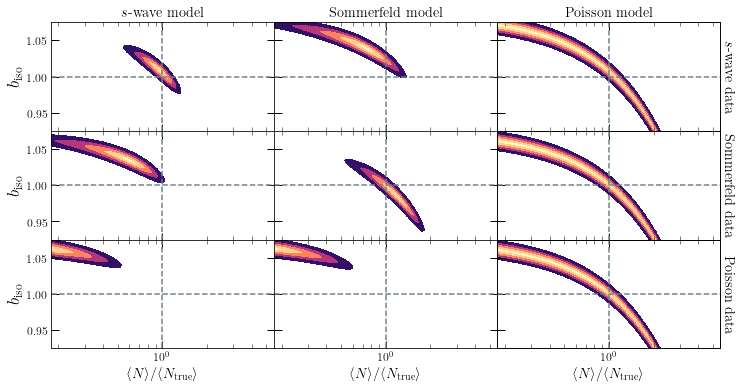

In [30]:
fig, axss = plt.subplots(ncols=3, nrows=3, figsize=(12, 6), sharey=True, sharex=True, gridspec_kw={'wspace': 0, 'hspace': 0})
i = 0
lw = 5
zorder = 1
# p['fwimp'] *= 1e98
# print(p['fwimp'])
# shift_som = 1 / 0.0209

from matplotlib import cm
cmap = cm.magma_r
axs = axss[0]
levels = [0, 1/2, 4/2, 9/2, 16/2, 25/2]

# fwimps /= 8 * np.pi
# p['fwimp'] /= 8 * np.pi
for i in range(3):
    for ax, s, lab in zip(axss[i], SS[i], ['s-wave L', 'som L', 'poisson L']):
        colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
        
        for expdat, expo in zip(s, exposure_search):
            indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
#             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            con = ax.contourf(fwimps / p['fwimp'], begs, (0.5*(expdat - expdat.min())), cmap=cmap, levels=levels)
            print([0.5 * expdat.min() - 4, 0.5 * expdat.min() - 1])
            print(con.levels)
            ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)

        ax.set_xscale('log')

# for ax, s, lab in zip(axs, SS[0], ['s-wave L', 'som L', 'poisson L']):
#     colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
#     for expdat, expo in zip(s, exposure_search):
#         indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
#         if lab == 'som L':
# #             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.contourf(fwimps / p['fwimp'], begs, (-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.axhline(1, ls='--', color='xkcd:steel gray')
# #             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
# #             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
# #             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
#         else:
# #             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.contourf(fwimps / p['fwimp'], begs, (-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.axhline(1, ls='--', color='xkcd:steel gray')
# #             ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
# #             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
# #             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

#     ax.set_xscale('log')
    
# axs = axss[1]
# # p['fwimp'] /=100
# for ax, s, lab in zip(axs, SS[1], ['s-wave L', 'som L', 'poisson L']):
#     colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
#     for expdat, expo in zip(s, exposure_search):
#         indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
#         if lab == 'som L' or lab == 'poisson L':
# #             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.contourf(fwimps / p['fwimp'], begs, (-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.axhline(1, ls='--', color='xkcd:steel gray')
# #             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
# #             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
# #             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
#         else:
# #             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.contourf(fwimps / p['fwimp'], begs, (-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.axhline(1, ls='--', color='xkcd:steel gray')
# #             ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
# #             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
# #             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

#     ax.set_xscale('log')
    
# axs = axss[2]
# # p['fwimp'] /=100
# for ax, s, lab in zip(axs, SS[2], ['s-wave L', 'som L', 'poisson L']):
#     colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
#     for expdat, expo in zip(s, exposure_search):
#         indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
#         if lab == 'som L' or lab == 'poisson L':
# #             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.contourf(fwimps / p['fwimp'], begs, (-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.axhline(1, ls='--', color='xkcd:steel gray')
# #             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
# #             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
# #             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
#         else:
# #             ax.contourf(fwimps / p['fwimp'], begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.contourf(fwimps / p['fwimp'], begs, (-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
#             ax.axvline(p['fwimp'] / p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.axhline(1, ls='--', color='xkcd:steel gray')
# #             ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
# #             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
# #             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

#     ax.set_xscale('log')
# p['fwimp'] *= 100 
for ax in axss[-1]:
#     ax.set_xlabel(r'$f_\mathrm{WIMP}$', fontsize='large')
#     ax.set_xlabel(r'$\Phi_\mathrm{PP}$', fontsize='large')
    ax.set_xlabel(r'$\langle N\rangle/\langle N_\mathrm{true}\rangle$', fontsize='large')
    
axss[0, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[1, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')
axss[2, 0].set_ylabel(r'$b_\mathrm{iso}$', fontsize='x-large')

ax = axss[0, -1].twinx()
ax.set_ylabel('$s$-wave data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[1, -1].twinx()
ax.set_ylabel('Sommerfeld data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[2, -1].twinx()
ax.set_ylabel('Poisson data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

axss[0, 0].set_title(r'$s$-wave model')
axss[0, 1].set_title('Sommerfeld model')
axss[0, 2].set_title('Poisson model')
    
# axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/plots/llhds_2d.pdf')

Add:
- Float beg but fix bg to 0.97
- Float beg w/ same bg
- Generate w/ no DM signal and fit s/som/poi (null test)
- Add to overleaf
- 

35.55558538599871


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


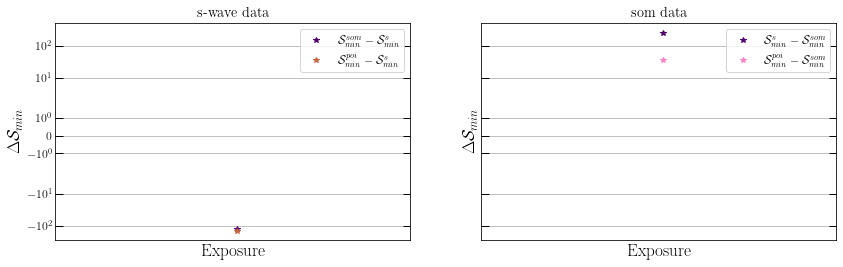

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

ax = axs[0]
s_S, som_S, poisson_S = SS[0]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, -max_swave + max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{s}$')
ax.plot(exposure_search, -max_swave + max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{s}$')
# ax.plot(exposure_search, max_som - max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{poi}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
 
ax = axs[1]
s_S, som_S, poisson_S = SS[1]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, max_swave - max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{som}$')
# ax.plot(exposure_search, max_swave - max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{poi}$')
ax.plot(exposure_search, - max_som + max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{som}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
print(max_poi - max_som)
axs[0].set_title('s-wave data')
axs[1].set_title('som data')

fig.savefig('./output/deltaS_2d.pdf')

NameError: name 'mean' is not defined

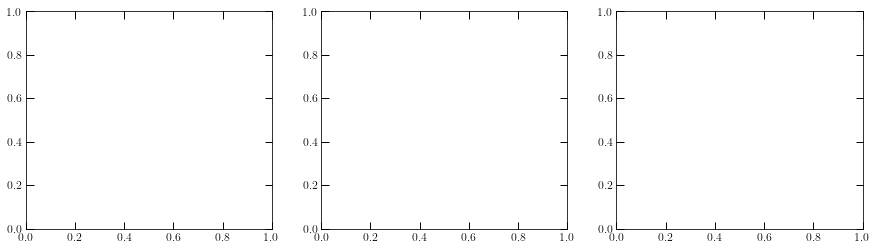

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(exposure_search, mean, label='mean', marker='o', ms=10)
axs[0].set_title('mean counts')
axs[1].plot(exposure_search, meanpc, label='P(C) mean', marker='o', ms=10)
axs[1].set_title('mean P(C)')
axs[2].plot(exposure_search, total, label='P(C) mean', marker='o', ms=10)
axs[2].set_title('total counts')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, np.log10(s_S), cmap=cm.jet, shading='auto')
fig.colorbar(pc, label='S for s-wave');

In [ ]:
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)